In [19]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import re
  
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation
from keras.layers import GRU, SimpleRNN

In [21]:
with open('/Users/maddiegupta/Desktop/train.txt', 'r') as file:
    train_text = file.read()
    
with open('/Users/maddiegupta/Desktop/test.txt', 'r') as file:
    test_text = file.read()

vocabulary = sorted(list(set(train_text + test_text)))
vocab_size = len(vocabulary)

# Dictionaries to go from a character to index and vice versa
char_to_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_to_char = dict((i, c) for i, c in enumerate(vocabulary))

In [23]:
def clean_text(text):
    # Remove the Byte Order Mark (BOM) if it exists
    cleaned_text = text.replace('\ufeff', '')
    
    # Remove unwanted characters (if any) using regular expressions
    # For example, removing digits, parentheses, and punctuation not needed:
    cleaned_text = re.sub(r'[^\w\s\'\n]', '', cleaned_text)
    
    # Optional: Remove any extra spaces or weird line breaks
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    cleaned_text = cleaned_text.lower()
    
    return cleaned_text
    
train_text = clean_text(train_text)
test_text = clean_text(test_text)

In [25]:
# The first 500 characters of our training set
train_text[0:500]

'apii jiibay bi dagooshinod okanan nandawaabandaanan gii gaadooyaan baatiindoon ishkweyaang ndodengwekaajigan nisimdanaashiniswi beshabiiaag manidoominensag inaabiiginaag oningwiiganan gaawiin tesiinon onzowan gaawiin tesiinon niizhtanaashiniizhwaaswi nindayaanan wii aabjitooyaan jiezhininjiishiyaan maage giiwitaajiishinidiying jimaamwizhibiiamaang dibaajimowinan ewaamjigaadeg miidash dibishkoo makwa ningwayakogaabow gichikaanan biiskamowaad mashkawiziwinan jimaajaayaan okanensan agaasin apii ene'

In [27]:
print("The vocabulary contains", vocab_size, "characters")
print("The training set contains", len(train_text) ,"characters")
print("The test set contains", len(test_text) ,"characters")

The vocabulary contains 44 characters
The training set contains 73265 characters
The test set contains 419 characters


Here's a peek at our training set.

In [30]:
#prepare one hot encoding with train_data and train_labels from train_text
sequence_length = 100  # Length of each sequence (you can adjust this)

# Prepare input and output sequences
train_data = []
train_labels = []

for i in range(0, len(train_text) - sequence_length):
    # Get a sequence of characters as input
    input_seq = train_text[i: i + sequence_length]
    # Get the next character as the target label
    label = train_text[i + sequence_length]
    
    # Convert the input sequence into a list of indices (from char_to_indices)
    input_seq_indices = [char_to_indices[char] for char in input_seq]
    
    # Append to the training data
    train_data.append(input_seq_indices)
    
    # Append the label (as an index)
    train_labels.append(char_to_indices[label])

# Now we need to one-hot encode the data and labels
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Convert train_data to one-hot encoding
train_data_one_hot = np.zeros((len(train_data), sequence_length, vocab_size), dtype=bool)

for i, seq in enumerate(train_data):
    for t, char_idx in enumerate(seq):
        train_data_one_hot[i, t, char_idx] = 1

# Convert train_labels to one-hot encoding
train_labels_one_hot = np.zeros((len(train_labels), vocab_size), dtype=bool)

for i, label_idx in enumerate(train_labels):
    train_labels_one_hot[i, label_idx] = 1

In [31]:
# load json and create model
json_file = open('/Users/maddiegupta/Desktop/q2_data/GRU_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

GRU_model = model_from_json(loaded_model_json)
GRU_model.load_weights("/Users/maddiegupta/Desktop/q2_data/GRU_model.h5")

In [32]:
# Compile the GRU model with a loss function and optimizer
GRU_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Graphing the loss at each epoch to see the ideal training level 
# Fine-tune the model and save the training history
history = GRU_model.fit(train_data_one_hot, train_labels_one_hot, validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5
915/915 [==============================] - 759s 828ms/step - loss: 2.1121 - val_loss: 2.1002
Epoch 2/5
915/915 [==============================] - 944s 1s/step - loss: 1.7269 - val_loss: 2.0729
Epoch 3/5
915/915 [==============================] - 1489s 2s/step - loss: 1.5469 - val_loss: 2.0380
Epoch 4/5
915/915 [==============================] - 773s 845ms/step - loss: 1.4044 - val_loss: 2.0738
Epoch 5/5
915/915 [==============================] - 983s 1s/step - loss: 1.2796 - val_loss: 2.0807


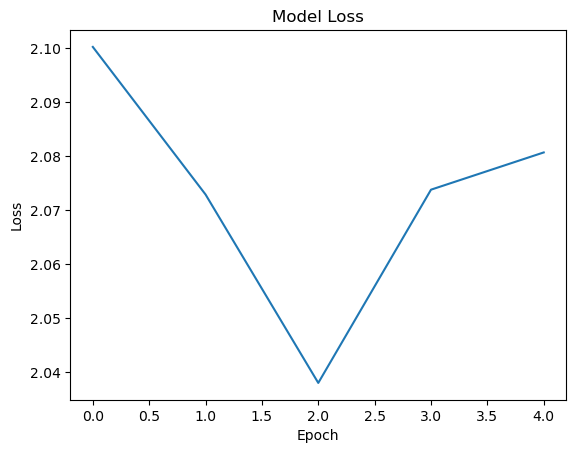

In [33]:
# Plot the loss at each epoch
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Now, we plot the loss by epoch for the model. Each epoch represents another pass over the data by the model. We want the epoch where the lowest loss is, indicating that the model is learning but not memorizing the data. You can see the lowest loss for the Anishinaabemowin model is at 2 epochs. It is interesting that the model needs less passes over the data than the English model to learn it similarly well. 

In [35]:
# retraining with the ideal epochs we found
json_file = open('/Users/maddiegupta/Desktop/q2_data/GRU_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

GRU_model = model_from_json(loaded_model_json)
GRU_model.load_weights("/Users/maddiegupta/Desktop/q2_data/GRU_model.h5")

GRU_model.compile(optimizer='adam', loss='categorical_crossentropy')

history = GRU_model.fit(train_data_one_hot, train_labels_one_hot, validation_split=0.2, epochs=2, batch_size=32)

Epoch 1/2
1830/1830 [==============================] - 2311s 1s/step - loss: 2.0163 - val_loss: 2.1260
Epoch 2/2
1830/1830 [==============================] - 2330s 1s/step - loss: 1.6239 - val_loss: 2.0711


In [45]:
# Helper function
weights_GRU = GRU_model.get_weights()

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sample_text_GRU(weights, prompt, N):
    '''
    Uses a pretrained GRU to generate text, starting from a prompt,
    only using the weights and numpy commands
            Parameters:
                    weights (list): Weights of the pretrained GRU model
                    prompt (string): Start of generated sentence
                    N (int): Total length of output sentence
            Returns:
                    output_sentence (string): Text generated by GRU
    '''
    # Extracting weights and biases
    # Dimensions of matrices are same format as lecture slides
    
    # GRU Layer 
    W_ux, W_rx, W_hx = np.split(weights[0].T, 3, axis = 0)
    W_uh, W_rh, W_hh = np.split(weights[1].T, 3, axis = 0)
    
    bias = np.sum(weights[2], axis=0)
    b_u, b_r, b_h = np.split(np.expand_dims(bias, axis=1), 3)

    # Linear (dense) layer
    W_y = weights[3].T
    b_y = np.expand_dims(weights[4], axis=1)
    
    # Initiate hidden state
    h = np.zeros((W_hh.shape[0], 1))
    
    # -----------------------------------------------
    m = len(prompt)
    # Initiate the output sentence
    char_ind = char_to_indices[prompt[0]]
    x = np.zeros((vocab_size, 1))
    x[char_ind] = 1
    output_sentence = prompt[0]

    for t in range(1, N):
        # Calculate update and reset gates
        Gamma_u = sigmoid(np.dot(W_ux, x) + np.dot(W_uh, h) + b_u)
        Gamma_r = sigmoid(np.dot(W_rx, x) + np.dot(W_rh, h) + b_r)
        
        # Calculate hidden states
        c = np.tanh(np.dot(W_hx, x) + Gamma_r *  np.dot(W_hh, h) + b_h)
        h = Gamma_u * h + (1 - Gamma_u) * c
        
        # No prediction necessary, just add next char in the prompt
        if t < m:
            char_ind = char_to_indices[prompt[t]]
            output_sentence += prompt[t]
            
        # Predict the next character and add to output sentence
        if t >= m:
            # Calculate the output states
            y = np.dot(W_y, h) + b_y
            # Calculate the probability distribution
            p = np.exp(y) / np.sum(np.exp(y))
            # Sample next character in sentence
            char_ind = np.random.choice(range(vocab_size), p=p.ravel())
            pred_char = indices_to_char[char_ind]
            output_sentence += pred_char
            
        # Obtain the one-hot encoding of next character
        x = np.zeros((vocab_size, 1))
        x[char_ind] = 1
        
    return output_sentence

In [47]:
print(sample_text_GRU(weights_GRU, 
                      'kwe',
                      100))

kwedong niniibawaad gaaakwiijiywag maabii kwiik desh waa maanwewins niningiishkwiiwigadegidow aniw a


The generation is not too bad. It has some misspellings and doesn't make sense as a sentence, but it follows the correct vowel and consonent patterns while putting 2-3 letters in a row correctly. It is not as good as the N-Gram, but also exhibits more learning than an N-Gram does, and less memorization. 

In [26]:
#test with training text 

def evaluate_GRU_on_test(weights, test_text, N):
    '''
    Evaluates how well the GRU model performs on the test_text
            Parameters:
                    weights (list): Weights of the pretrained GRU model
                    test_text (string): Test text to compare against generated text
                    N (int): Number of characters to generate
            Returns:
                    accuracy (float): Accuracy of the model on the test text
    '''
    correct_predictions = 0
    total_predictions = 0
    
    # Choose a starting prompt from the test text
    prompt_length = 10  # You can vary this value
    for i in range(len(test_text) - prompt_length - N):
        prompt = test_text[i:i+prompt_length]
        true_text = test_text[i+prompt_length:i+prompt_length+N]
        
        # Generate text using the GRU model
        generated_text = sample_text_GRU(weights, prompt, N)
        
        # Compare generated text to the actual test text
        for j in range(min(len(generated_text), len(true_text))):
            if generated_text[j] == true_text[j]:
                correct_predictions += 1
            total_predictions += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

In [28]:
N = 100  # Number of characters to generate
accuracy = evaluate_GRU_on_test(weights_GRU, test_text, N)
print(f"Model accuracy on test text: {accuracy:.2f}")

Model accuracy on test text: 0.11


An accuracy of over ten percent is high for the small amount of data we have. It is also very notable that it has a higher accuracy than the English GRU does. I was really surprised by that, and think it sets a great stage for future research into this phenomenon specifically. 

In [55]:
def perplexity_GRU(weights, test_data, m):
    # Extracting weights and biases
    # Dimensions of matrices are same format as lecture slides
    
    # GRU Layer 
    W_ux, W_rx, W_hx = np.split(weights[0].T, 3, axis = 0)
    W_uh, W_rh, W_hh = np.split(weights[1].T, 3, axis = 0)

    bias = np.sum(weights[2], axis=0)
    b_u, b_r, b_h = np.split(np.expand_dims(bias, axis=1), 3)

    # Linear (dense) layer
    W_y = weights[3].T
    b_y = np.expand_dims(weights[4], axis=1)
    
    # Initiate hidden state
    h = np.zeros((W_hh.shape[0], 1))
    
    # -----------------------------------------------
    prompt = test_data[0:m]
    N = len(test_data)
    # Initiate array of probabilities
    p_array = np.zeros(N-m)
    char_ind = char_to_indices[prompt[0]]
    x = np.zeros((vocab_size, 1))
    x[char_ind] = 1

    for t in range(1, N):
        # Calculate update and reset gates
        Gamma_u = sigmoid(np.dot(W_ux, x) + np.dot(W_uh, h) + b_u)
        Gamma_r = sigmoid(np.dot(W_rx, x) + np.dot(W_rh, h) + b_r)
        
        # Calculate hidden states
        c = np.tanh(np.dot(W_hx, x) + Gamma_r * np.dot(W_hh, h) + b_h)
        h = Gamma_u * h + (1 - Gamma_u) * c
        
        # No prediction necessary, just add next char in the prompt
        if t < m:
            char_ind = char_to_indices[test_data[t]]
            
        # Predict the next character and add to output sentence
        if t >= m:
            # Calculate the output states
            y = np.dot(W_y, h) + b_y
            # Calculate the probability distribution
            p = np.exp(y) / np.sum(np.exp(y))
            # Get the next character in the test set
            char_ind = char_to_indices[test_data[t]]
            # Add the probability corresponding to test sequence to list
            p_array[t-m] = p[char_ind]
            
        # Obtain the one-hot encoding of next character
        x = np.zeros((vocab_size, 1))
        x[char_ind] = 1

    return np.log(p_array), np.exp((-1/(N-m)) * np.sum(np.log(p_array)))

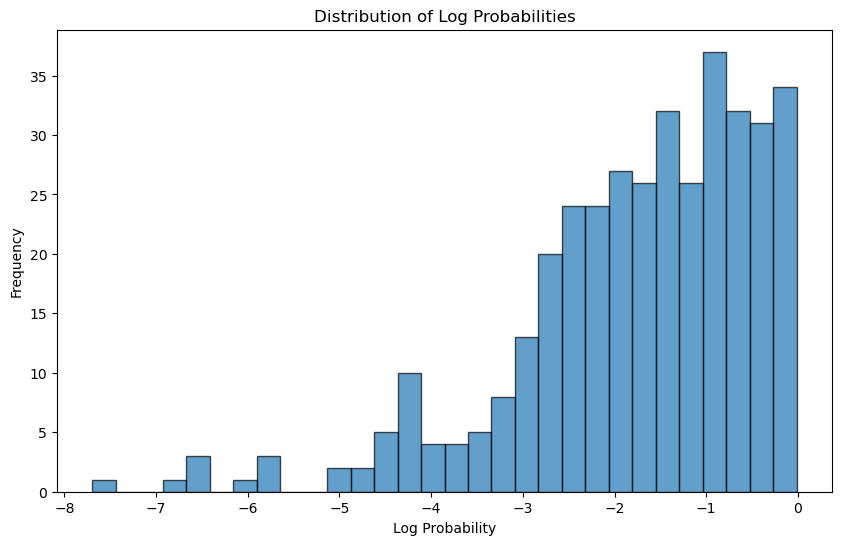

Perplexity of the model: 5.8655089401998834


In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Run the function to get log probabilities and perplexity
log_probs, perplexity = perplexity_GRU(weights_GRU, test_text, 44)

# Plot histogram of the log probabilities
plt.figure(figsize=(10, 6))
plt.hist(log_probs, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Log Probabilities")
plt.xlabel("Log Probability")
plt.ylabel("Frequency")
plt.show()

print(f"Perplexity of the model: {perplexity}")


The perplexity of the Anishinaabemowin GRU is suprisingly a lot lower than the English model. 

These results are striking. Compared to the English GRU, the Anishinaabemowin GRU has a higher accuracy both qualitatively and quantiatively, less passes over the data needed, and a lower perplexity. All of these metrics point to the Anishinaabemowin model actually being more successful than the English model in our small dataset environment. 